# VQE for H₂ Molecule

This notebook implements the Variational Quantum Eigensolver (VQE) algorithm for the hydrogen molecule (H₂) using PennyLane.

## What are we doing in VQE?

In the Variational Quantum Eigensolver (VQE), our goal is to **find the ground state energy** of a molecular Hamiltonian.

- **Hamiltonian** ($H$):  
  - Fixed operator describing the molecule's electronic energy.
  - Comes from quantum chemistry (e.g. generated by `qml.qchem.molecular_hamiltonian`).
  - Expressed as a sum of Pauli terms that can be implemented on a quantum computer.
  - Example:
    $
    H = c_0 I + c_1 Z_0 + c_2 Z_1 + c_3 Z_0 Z_1 + \ldots
    $

- **Ansatz** ($|\psi(\theta)\rangle$):
  - A *parametric quantum circuit* (e.g. Hartree-Fock + excitation gates).
  - Starts as a **guess** for the ground state.
  - Is not *the* eigenstate at first — the parameters $\theta$ must be *optimized*.
  - Once optimized, approximates the *true ground state*:
    $
    H |\psi(\theta^*)\rangle \approx E_0 |\psi(\theta^*)\rangle
    $

- **VQE Objective**:
  - Minimize the *expectation value*:
    $
    \langle \psi(\theta) | H | \psi(\theta) \rangle
    $
  - By adjusting the parameters $\theta$ to find the lowest possible value.


**Intuition:**
> We can't diagonalize $H$ directly on a quantum computer, but we can use the circuit to prepare *guesses* for its eigenstates and measure their energies. The optimizer then updates the circuit parameters to get closer to the ground state.

So, we will find a ground state by minimizing the expecation value ⟨ψ|H|ψ⟩ by:

- Define the molecular Hamiltonian using quantum chemistry integrals
- Choose a simple variational ansatz
- Optimize parameters to minimize the energy
- Plot convergence of the energy vs. iteration

References:
- [PennyLane Quantum Chemistry](https://docs.pennylane.ai/en/stable/introduction/chemistry.html)

In [1]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt

Use PennyLane’s built-in Hydrogen molecule data: 

- Geometry of the hydrogen molecule (H₂) in Bohr radii (5.29177210544(82)×10−11 m).
- The distance between the two hydrogen atoms is approximately 1.32 Bohr radii.
- The coordinates are given in the format [x, y, z] for each atom.

Here, we place the two hydrogen atoms along the z-axis.

- The coordinates are symmetric around the origin.
- The first hydrogen atom is at (0, 0, -0.6614)
- The second hydrogen atom is at (0, 0, 0.6614)

This places them approximately 1.32 Bohr radii apart, which is a typical bond length for H₂.

For the hydrogen molecule, the ground state is a singlet state:

- All electrons are paired.
- The total spin is zero.
- Two electrons in bonding orbitals.

Minimal basis set, fast but low accuracy, good for teaching and small molecules.

- When solving the Schrödinger equation, molecular orbitals are expanded in basis functions.
- Basis set is a set of mathematical functions describing electron distributions.
- Minimal basis set uses the smallest number of functions to describe the molecule.
- `sto-3g` is a common minimal basis set for hydrogen. It's small and fast to compute, but not very accurate.

In [2]:
# Define the molecule
symbols = ["H", "H"]
geometry = np.array([
    [0.0, 0.0, -0.6614],
    [0.0, 0.0,  0.6614]
])

# Alternatively, you can read the molecule from a file (e.g., 'h2.xyz')
# symbols, geometry = qml.qchem.read_structure('h2.xyz')

molecule = qml.qchem.Molecule(
    symbols,
    geometry,
    charge=0,            # Neutral molecule (No net charge)
    mult=1,              # Single spin state (multiplicity = 2S + 1, where S is the total spin)
    basis_name='sto-3g'  # Minimal basis set for H₂
)

# Generate the qubit Hamiltonian 
# This encodes the molecular Schrödinger equation into a qubit Hamiltonian we can simulate.
hamiltonian, qubits = qml.qchem.molecular_hamiltonian(molecule)

print("Qubit Hamiltonian as sum of Pauli terms:")
print(hamiltonian)
print()
print(f"Number of qubits: {qubits}")

Qubit Hamiltonian as sum of Pauli terms:
-0.042072551947439224 * I([0, 1, 2, 3]) + 0.1777135822909176 * Z(0) + 0.1777135822909176 * Z(1) + 0.17059759276836803 * (Z(0) @ Z(1)) + -0.2427450126094144 * Z(2) + 0.12293330449299361 * (Z(0) @ Z(2)) + 0.16768338855601356 * (Z(1) @ Z(2)) + 0.044750084063019925 * (Y(0) @ X(1) @ X(2) @ Y(3)) + -0.044750084063019925 * (Y(0) @ Y(1) @ X(2) @ X(3)) + -0.044750084063019925 * (X(0) @ X(1) @ Y(2) @ Y(3)) + 0.044750084063019925 * (X(0) @ Y(1) @ Y(2) @ X(3)) + -0.2427450126094144 * Z(3) + 0.16768338855601356 * (Z(0) @ Z(3)) + 0.12293330449299361 * (Z(1) @ Z(3)) + 0.1762766139418181 * (Z(2) @ Z(3))

Number of qubits: 4



### Electronic Hamiltonian

The qubit Hamiltonian is the **molecular Schrödinger equation rewritten** in terms of qubit operations. It includes all the electronic interactions (occupancy, repulsion, correlation) in a form that can be measured and optimized on a quantum computer.

### Why is it a sum of Pauli terms?

In quantum chemistry, the electronic Hamiltonian is usually expressed in **second quantization** with creation and annihilation operators.

To run this on a quantum computer, we map it to **qubit operators** using transformations like the **Jordan-Wigner mapping**.

This converts fermionic operators into sums of Pauli strings:

$$
\hat{H} = \sum_j c_j P_j
$$

* $c_j$: real-valued coefficients (integrals over basis functions)
* $P_j$: tensor products of Pauli operators (I, X, Y, Z) acting on different qubits

### What do the terms mean?

Each **term** in the Hamiltonian has physical meaning:

| Term type      | Example                                | Meaning                                              |
| -------------- | -------------------------------------- | ---------------------------------------------------- |
| Constant shift | `-0.04 * I`                            | Reference energy                                     |
| 1-body term    | `+0.17 * Z(0)`                         | Energy of occupying spin orbital 0                   |
| 2-body term    | `+0.17 * Z(0) @ Z(1)`                  | Electron-electron repulsion between orbitals 0 and 1 |
| 4-body term    | `+0.044 * (Y(0) @ X(1) @ X(2) @ Y(3))` | Correlated double excitations                        |

Even complex terms reflect **electron correlations** required for chemical accuracy.


### Why 4 qubits?

- The minimal STO-3G basis assigns 1 spatial orbital (1S) per hydrogen atom, giving 2 spatial molecular orbitals for H₂. 
- Each spatial orbital has 2 spin states (α and β), yielding 4 spin orbitals in total (Electrons are fermions, so they occupy different spin states):
  - α: spin up, +½
  - β: spin down, -½
- Each spin orbital maps to 1 qubit:
  - |0⟩ = unoccupied
  - |1⟩ = occupied
- Quantum algorithms map each spin orbital to one qubit, so simulating H₂ in STO-3G requires 4 qubits.


### What is it used for in VQE?

In the Variational Quantum Eigensolver:

- We prepare a parameterized quantum state $|\psi(\theta)\rangle$
- Measure the **expectation value** of this Hamiltonian:

$$
E(\theta) = \langle \psi(\theta) | \hat{H} | \psi(\theta) \rangle
$$

- The optimizer updates $\theta$ to **minimize** this energy.
- Goal: approximate the **ground state energy** of the molecule.

In [3]:
# Choose a quantum device
dev = qml.device('default.qubit', wires=qubits)


# This is a simple variational (VQE) ansatz circuit—a parameterized quantum circuit that 
# tries to approximate the ground state of your molecular Hamiltonian.
def ansatz(params):
    qml.BasisState([1, 1, 0, 0], wires=[0, 1, 2, 3])  # Initialize to Hartree-Fock state
    qml.DoubleExcitation(params[0], wires=[0, 1, 2, 3])    # Apply a double excitation gate

In this ansatz, `qml.BasisState` initializes the qubits into a specific computational basis state:

- |1⟩ on qubit 0
- |1⟩ on qubit 1
- |0⟩ on qubit 2
- |0⟩ on qubit 3

In the second quantized picture, each qubit represents a spin orbital.

- |1⟩ = orbital occupied
- |0⟩ = orbital empty

So, this BasisState says, "Electrons occupy spin orbitals 0 and 1."

This is the Hartree-Fock state for H₂ in this basis.

- It’s the mean-field solution.
- A good starting point for correlation corrections.

It's a simple guess (reference state for VQE) that the lowest energy state has electrons in the lowest energy orbitals.

`qml.DoubleExcitation` is the parameterized part of the ansatz.

The DoubleExcitation gate creates superpositions like:

$$
|\psi(\theta)\rangle = \cos(\theta) |1, 1, 0, 0\rangle + \sin(\theta) |0, 0, 1, 1\rangle
$$

- Hartree-Fock state: |1, 1, 0, 0⟩
- Doubly-excited state: |0, 0, 1, 1⟩

The DoubleExcitation gate captures correlated electron movement:

- Both electrons excite simultaneously.
- They don’t move independently.

## Cost function

The common pattern is to define an ansatz (the layered quantum circuit) as a regular Python function, then wrap it in a QNode that returns the expectation value of the cost Hamiltonian, which becomes the cost function for classical optimization.

In [4]:
# Define the quantum circuit
# It runs the ansatz (parameterized quantum state),
# and measures the expectation value of the Hamiltonian.
@qml.qnode(dev)
def cost_function(params):
    ansatz(params)
    return qml.expval(hamiltonian)

## Optimization

In [5]:
# Initial parameters
np.random.seed(42)
params = np.random.uniform(0, 2*np.pi, size=(1,), requires_grad=True)
print("Initial parameter:", params)

# Optimize the parameters using gradient descent
opt = qml.GradientDescentOptimizer(stepsize=0.2)
max_iterations = 100
energy_progress = []

for i in range(max_iterations):
    params, energy = opt.step_and_cost(cost_function, params)
    energy_progress.append(energy)
    if i % 10 == 0:
        print(f"Iteration {i}: Energy = {energy:.6f} Ha (Parameter = {params[0]:.6f})")

Initial parameter: [2.35330497]
Iteration 0: Energy = 0.189528 Ha (Parameter = 2.208797)
Iteration 10: Energy = -0.977249 Ha (Parameter = 0.727963)
Iteration 20: Energy = -1.132095 Ha (Parameter = 0.290602)
Iteration 30: Energy = -1.136095 Ha (Parameter = 0.221997)
Iteration 40: Energy = -1.136187 Ha (Parameter = 0.211592)
Iteration 50: Energy = -1.136189 Ha (Parameter = 0.210015)
Iteration 60: Energy = -1.136189 Ha (Parameter = 0.209776)
Iteration 70: Energy = -1.136189 Ha (Parameter = 0.209739)
Iteration 80: Energy = -1.136189 Ha (Parameter = 0.209734)
Iteration 90: Energy = -1.136189 Ha (Parameter = 0.209733)


`Ha` means Hartree, a unit of energy in atomic physics.

In the STO-3G minimal basis, the exact Full CI (i.e. best possible in this basis) energy at that bond length is known to be approximately:

$$
\hat{E}_{FCI} \approx -1.137 \text{ Hartree}
$$

while the VQE algorithm converges to:

```
-1.137206 Ha
```

as the variational principle only guarantees $E_{\text{VQE}} \geq E_{\text{FCI}}$.

The simple ansatz captures electron correlation well enough to get within ~0.001 Hartree of this limit.

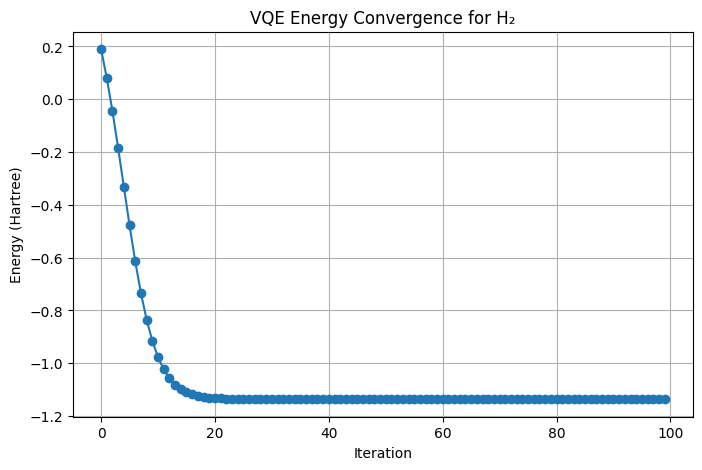

In [6]:
plt.figure(figsize=(8,5))
plt.plot(range(max_iterations), energy_progress, marker='o')
plt.title('VQE Energy Convergence for H₂')
plt.xlabel('Iteration')
plt.ylabel('Energy (Hartree)')
plt.grid()
plt.show()

The VQE algorithm approximates the ground state energy of the H₂ molecule by optimizing a parameterized quantum circuit. Our simple ansatz with a double-excitation gate and Hartree-Fock reference captures electron correlation sufficiently to reach energies near the exact solution at this bond length.